In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import joblib

In [2]:
df = pd.read_csv(r'all_breakdown.csv', parse_dates=['TIMESTAMP'])

In [3]:
df

,TIMESTAMP,BIOGAS,BIOMASS,GEOTHERMAL,Hour,SMALL HYDRO,SOLAR,SOLAR PV,SOLAR THERMAL,WIND TOTAL
0,2011-07-21 00:00:00,177.0,372.0,984.0,1.0,516.0,0.0,NaN,NaN,1607.0
1,2011-07-21 01:00:00,176.0,373.0,984.0,2.0,509.0,0.0,NaN,NaN,1619.0
2,2011-07-21 02:00:00,177.0,371.0,985.0,3.0,506.0,0.0,NaN,NaN,1660.0
3,2011-07-21 03:00:00,177.0,374.0,985.0,4.0,504.0,0.0,NaN,NaN,1633.0
4,2011-07-21 04:00:00,177.0,377.0,984.0,5.0,508.0,0.0,NaN,NaN,1520.0
...,...,...,...,...,...,...,...,...,...,...
67579,2013-01-28 19:00:00,209.0,331.0,924.0,20.0,404.0,NaN,0.0,0.0,2633.0
67580,2013-01-28 20:00:00,207.0,334.0,924.0,21.0,372.0,NaN,0.0,0.0,2540.0
67581,2013-01-28 21:00:00,208.0,342.0,926.0,22.0,372.0,NaN,0.0,0.0,2408.0
67582,2013-01-28 22:00:00,208.0,334.0,928.0,23.0,358.0,NaN,0.0,0.0,2274.0


In [9]:
# Convert TIMESTAMP to datetime index
data = df.set_index('TIMESTAMP')

data.dtypes

BIOGAS           float64
BIOMASS          float64
GEOTHERMAL       float64
Hour             float64
SMALL HYDRO      float64
SOLAR            float64
SOLAR PV         float64
SOLAR THERMAL    float64
WIND TOTAL       float64
dtype: object

In [10]:
data[['SOLAR' ,'SOLAR PV' ,'SOLAR THERMAL']].value_counts()

Series([], Name: count, dtype: int64)

In [11]:
# Resample the data to hourly frequency
data = data.resample('H').sum()

C:\Users\PENINAH\AppData\Local\Temp\ipykernel_5168\1234700209.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('H').sum()


In [12]:
# Check for missing values
data.isna().sum()

BIOGAS           0
BIOMASS          0
GEOTHERMAL       0
Hour             0
SMALL HYDRO      0
SOLAR            0
SOLAR PV         0
SOLAR THERMAL    0
WIND TOTAL       0
dtype: int64

In [13]:
data.shape

(67896, 9)

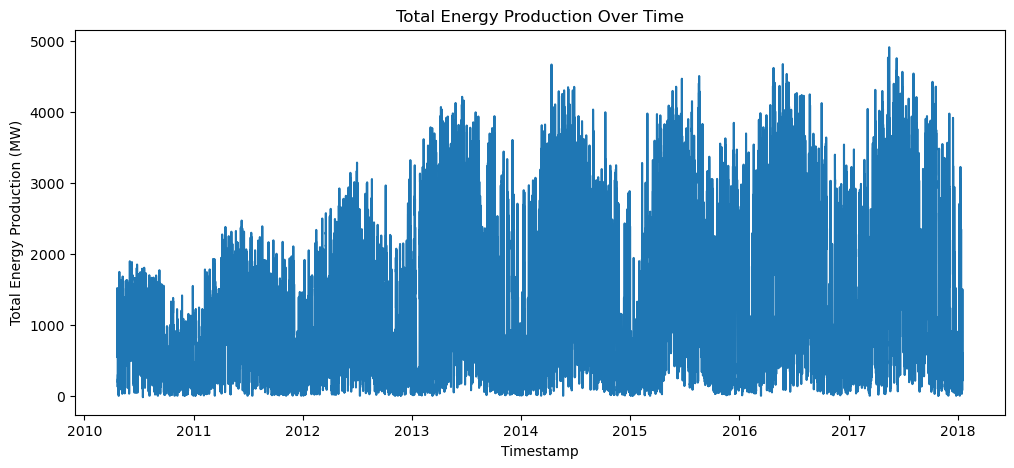

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['WIND TOTAL'])
plt.xlabel('Timestamp')
plt.ylabel('Total Energy Production (MW)')
plt.title('Total Energy Production Over Time')
plt.show()

In [15]:
import warnings
warnings.filterwarnings('ignore')

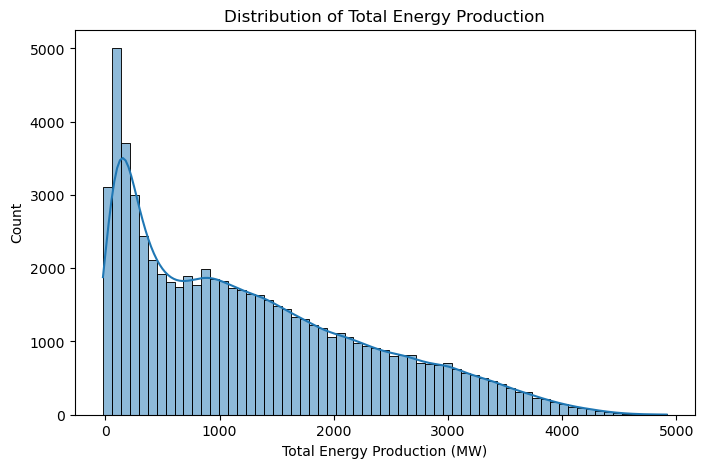

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(data['WIND TOTAL'], kde=True)
plt.xlabel('Total Energy Production (MW)')
plt.ylabel('Count')
plt.title('Distribution of Total Energy Production')
plt.show()

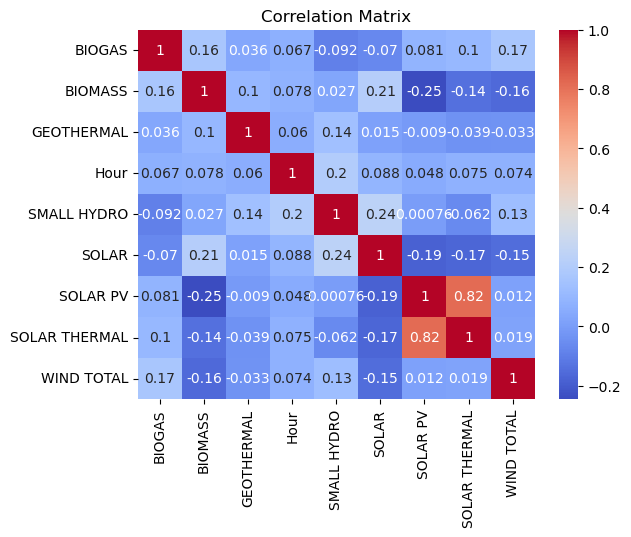

In [17]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [18]:
data_copy = data.copy()

In [19]:
data_copy['day'] = data_copy.index.day
data_copy['month'] = data_copy.index.month
data_copy['year'] = data_copy.index.year
data_copy['weekday'] = data_copy.index.dayofweek
data_copy['quarter'] = data_copy.index.quarter
data_copy['total_renewable'] = data_copy['BIOGAS'] + data_copy['BIOMASS'] + data_copy['GEOTHERMAL'] + data_copy['SMALL HYDRO'] + data_copy['SOLAR'] + data_copy['SOLAR PV'] + data_copy['SOLAR THERMAL']
data_copy['renewable_ratio'] = data_copy['total_renewable'] / data_copy['WIND TOTAL']

In [20]:
data_copy

,BIOGAS,BIOMASS,GEOTHERMAL,Hour,SMALL HYDRO,SOLAR,SOLAR PV,SOLAR THERMAL,WIND TOTAL,day,month,year,weekday,quarter,total_renewable,renewable_ratio
TIMESTAMP,,,,,,,,,,,,,,,,
2010-04-20 00:00:00,170.0,323.0,1056.0,1.0,250.0,0.0,0.0,0.0,632.0,20,4,2010,1,2,1799.0,2.846519
2010-04-20 01:00:00,169.0,318.0,1055.0,2.0,245.0,0.0,0.0,0.0,632.0,20,4,2010,1,2,1787.0,2.827532
2010-04-20 02:00:00,168.0,316.0,1058.0,3.0,240.0,0.0,0.0,0.0,677.0,20,4,2010,1,2,1782.0,2.632201
2010-04-20 03:00:00,168.0,318.0,1063.0,4.0,238.0,0.0,0.0,0.0,923.0,20,4,2010,1,2,1787.0,1.936078
2010-04-20 04:00:00,168.0,318.0,1066.0,5.0,247.0,0.0,0.0,0.0,875.0,20,4,2010,1,2,1799.0,2.056000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-16 19:00:00,240.0,339.0,974.0,20.0,495.0,0.0,0.0,0.0,213.0,16,1,2018,1,1,2048.0,9.615023
2018-01-16 20:00:00,239.0,334.0,976.0,21.0,461.0,0.0,0.0,0.0,235.0,16,1,2018,1,1,2010.0,8.553191
2018-01-16 21:00:00,239.0,334.0,971.0,22.0,451.0,0.0,0.0,0.0,288.0,16,1,2018,1,1,1995.0,6.927083


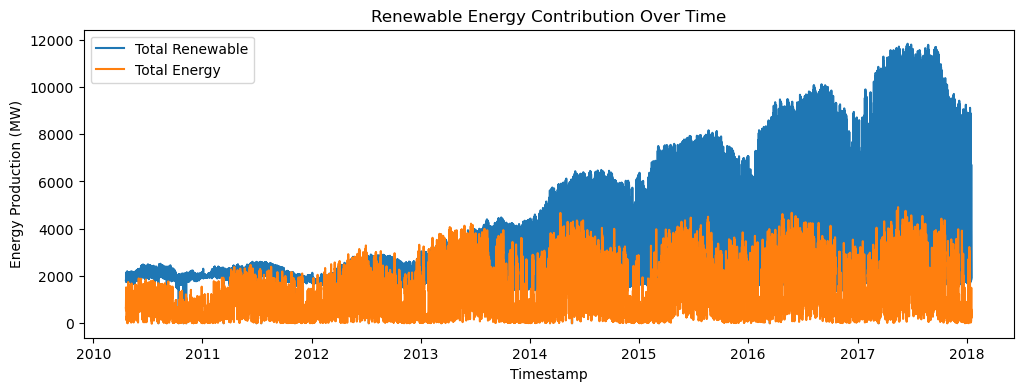

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(data_copy.index, data_copy['total_renewable'], label='Total Renewable')
plt.plot(data_copy.index, data_copy['WIND TOTAL'], label='Total Energy')
plt.xlabel('Timestamp')
plt.ylabel('Energy Production (MW)')
plt.title('Renewable Energy Contribution Over Time')
plt.legend()
plt.show()

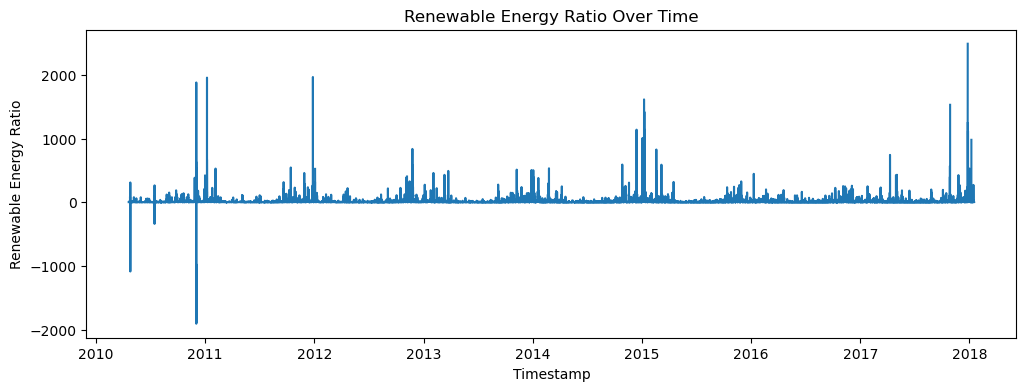

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(data_copy.index, data_copy['renewable_ratio'])
plt.xlabel('Timestamp')
plt.ylabel('Renewable Energy Ratio')
plt.title('Renewable Energy Ratio Over Time')
plt.show()

In [24]:
data_copy.isna().sum()

BIOGAS               0
BIOMASS              0
GEOTHERMAL           0
Hour                 0
SMALL HYDRO          0
SOLAR                0
SOLAR PV             0
SOLAR THERMAL        0
WIND TOTAL           0
day                  0
month                0
year                 0
weekday              0
quarter              0
total_renewable      0
renewable_ratio    315
dtype: int64

In [25]:
ready_df = data_copy.fillna(data_copy.median())

In [26]:
# Separate features and target
features = ['BIOGAS', 'BIOMASS', 'GEOTHERMAL', 'SMALL HYDRO', 'SOLAR', 'SOLAR PV', 'SOLAR THERMAL', 'Hour', 'day', 'month', 
            'year', 'weekday', 'quarter', 'total_renewable']
target = 'WIND TOTAL'

X = ready_df[features]
y = ready_df[target]

In [27]:
ready_df2 = ready_df[features]

In [28]:
print("Infinite values in X:", np.isinf(X).sum().sum())

Infinite values in X: 0


In [29]:
# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [31]:
# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [32]:
# Predict non-negative values
y_pred = xgb_model.predict(X_test)
y_pred = [max(0, y) for y in y_pred]  # Ensure non-negative predictions

In [33]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [34]:
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 96248.76
R-squared: 0.91


In [35]:
# Include predicted values in the DataFrame
predicted_values = xgb_model.predict(scaler.transform(X)) 
# Add predicted values to the DataFrame
ready_df['Predicted_TOTAL'] = predicted_values 

In [36]:
ready_df.head()

,BIOGAS,BIOMASS,GEOTHERMAL,Hour,SMALL HYDRO,SOLAR,SOLAR PV,SOLAR THERMAL,WIND TOTAL,day,month,year,weekday,quarter,total_renewable,renewable_ratio,Predicted_TOTAL
TIMESTAMP,,,,,,,,,,,,,,,,,
2010-04-20 00:00:00,170.0,323.0,1056.0,1.0,250.0,0.0,0.0,0.0,632.0,20,4,2010,1,2,1799.0,2.846519,637.942932
2010-04-20 01:00:00,169.0,318.0,1055.0,2.0,245.0,0.0,0.0,0.0,632.0,20,4,2010,1,2,1787.0,2.827532,651.028870
2010-04-20 02:00:00,168.0,316.0,1058.0,3.0,240.0,0.0,0.0,0.0,677.0,20,4,2010,1,2,1782.0,2.632201,685.655334
2010-04-20 03:00:00,168.0,318.0,1063.0,4.0,238.0,0.0,0.0,0.0,923.0,20,4,2010,1,2,1787.0,1.936078,897.831665
2010-04-20 04:00:00,168.0,318.0,1066.0,5.0,247.0,0.0,0.0,0.0,875.0,20,4,2010,1,2,1799.0,2.056000,914.504456


In [37]:
ready_df.to_csv('final_df.csv', index= False)

In [ ]:
# Feature Importance using SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(scaler.transform(X_test))


plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features)
plt.show()